- **Download link:** https://www.kaggle.com/datasets/rakannimer/air-passengers
- **Complete Video Tutorial:** https://youtu.be/H6UEywvWpn0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv('AirPassengers.csv')
df.set_index('Month', inplace=True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


eda

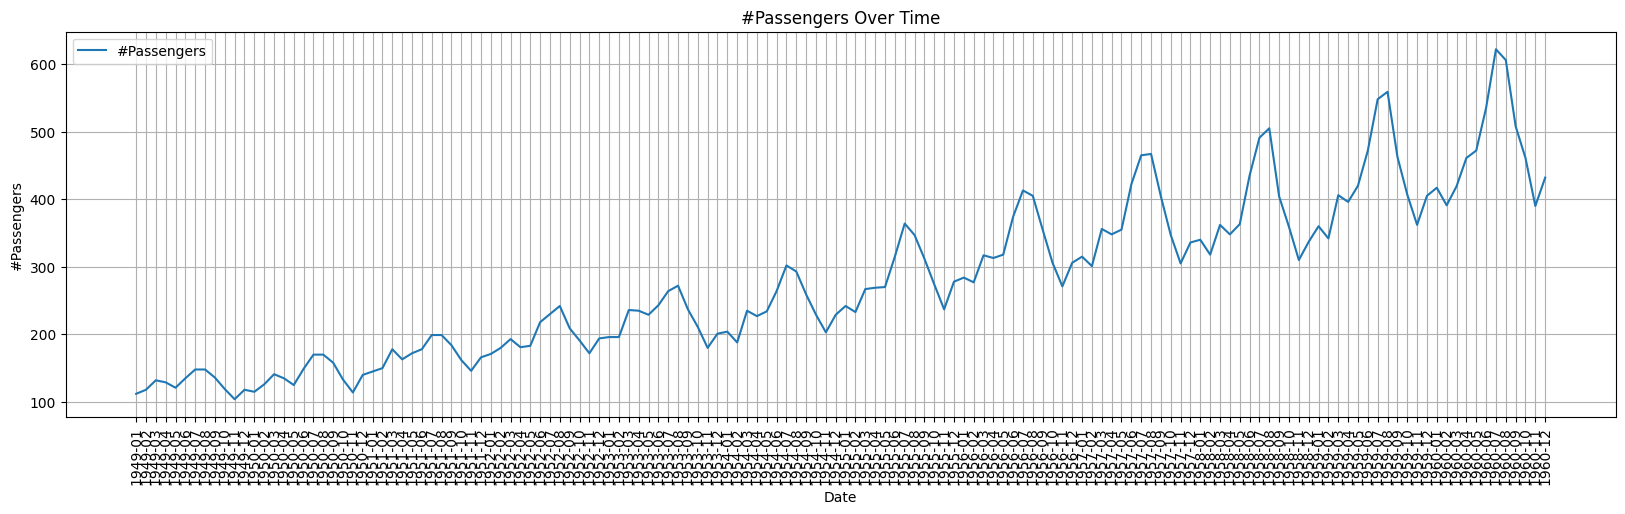

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(df.index, df['#Passengers'],label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [7]:
# perform seasonal decomposition
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
result

initial analysis

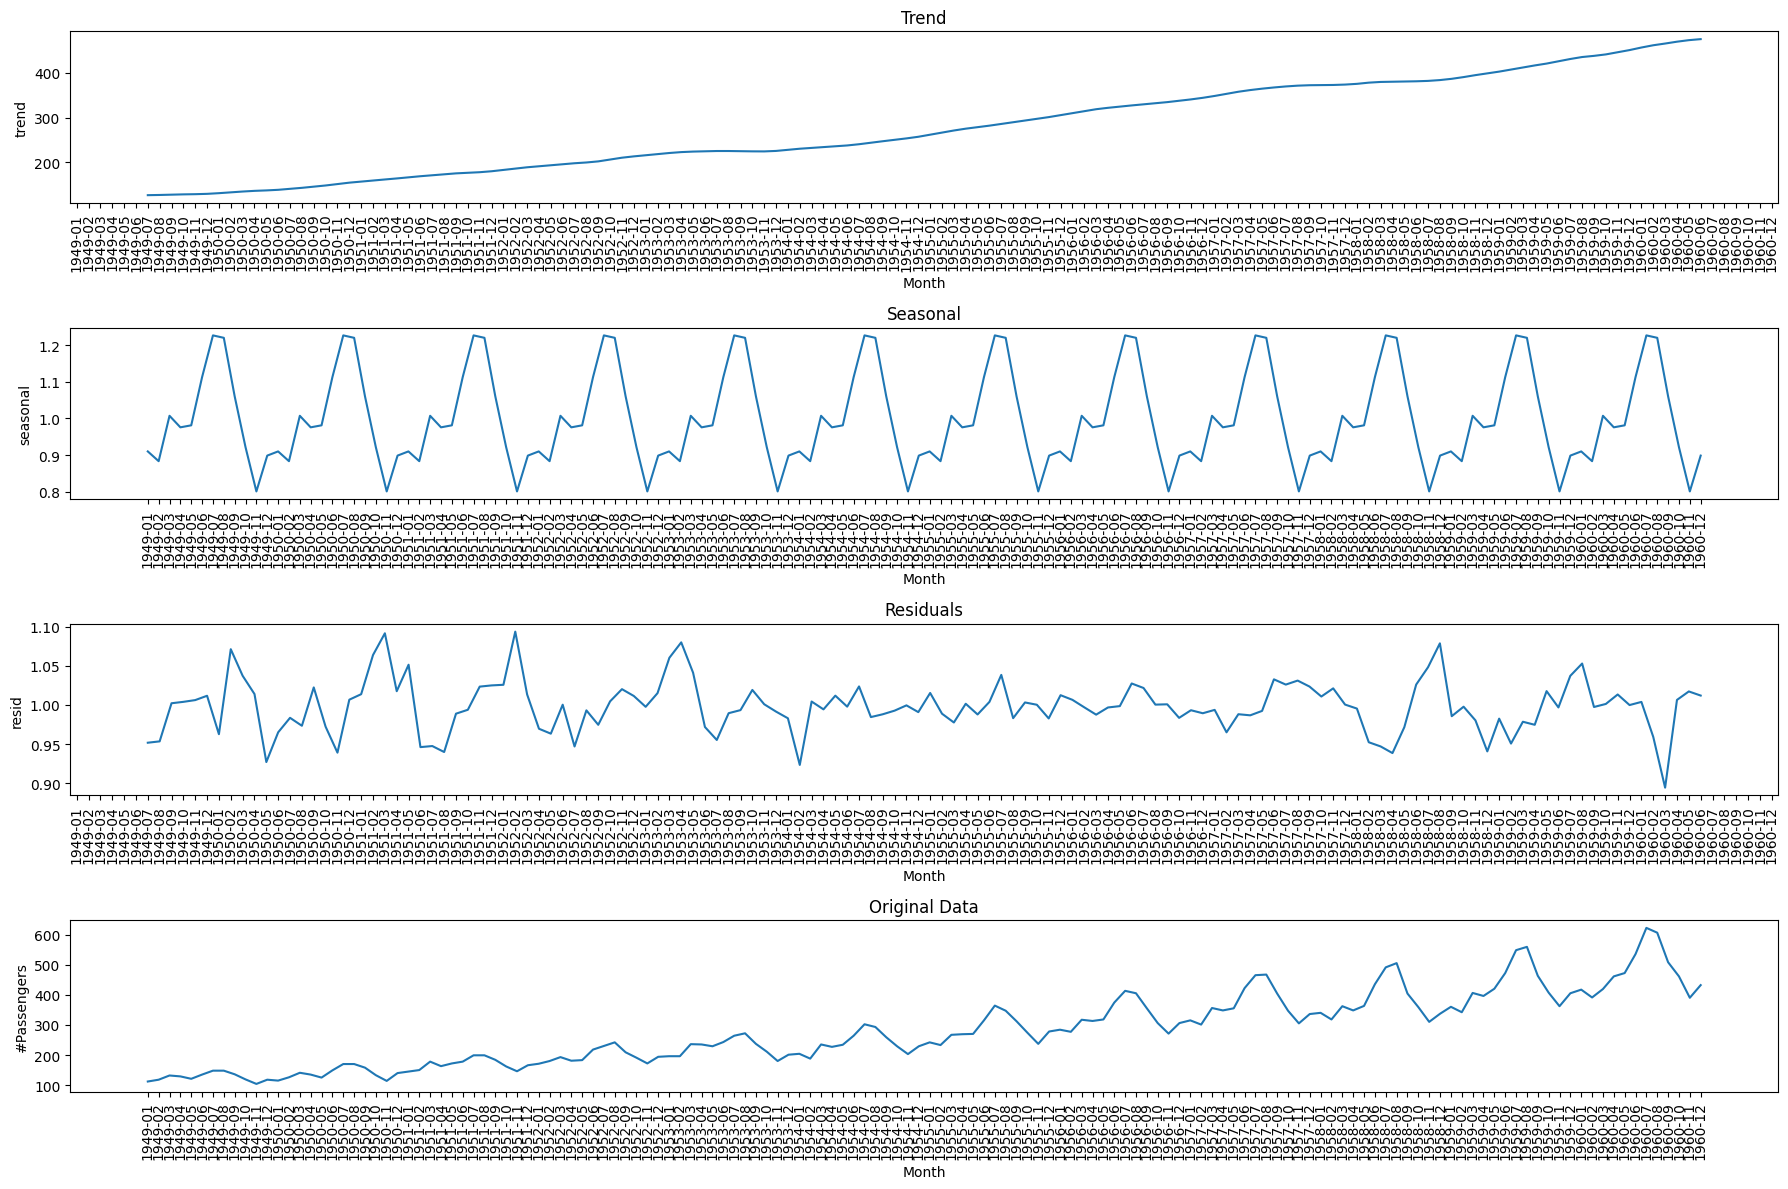

In [10]:
# plot the components in the graph
plt.figure(figsize=(18,12))

# trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)

# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)

# Residuals component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residuals')
plt.xticks(rotation=90)

# Original data
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

remove trend-differncing


In [11]:
seasonal_period = 12

In [12]:
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test

result = adfuller(df['#Passengers'], autolag='AIC') # Akaike Information Criterion
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641


hav to reduce p<0.05

In [14]:
# first order differencing
result = adfuller(df['#Passengers'].diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8292668241699994
p-value: 0.0542132902838255


In [18]:
# check for second order differencing
result = adfuller(df['#Passengers'].diff().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.384231542468505
p-value: 2.7328918500142407e-29


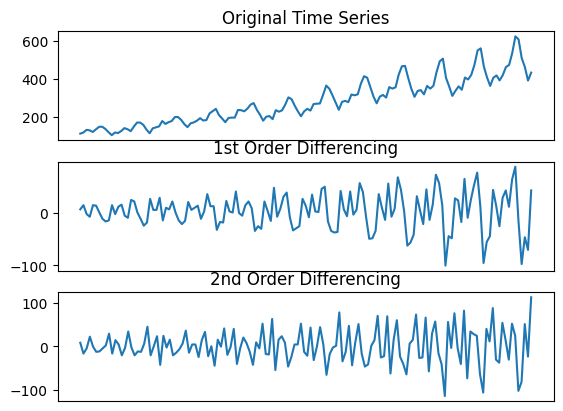

In [16]:
# plot the differencing values
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

the time series becomes stationary after first order differencing

define params for arima
- d = 1 order of differncing I
- p = 0 moving average PACF
- q = 0 auto regressive ACF

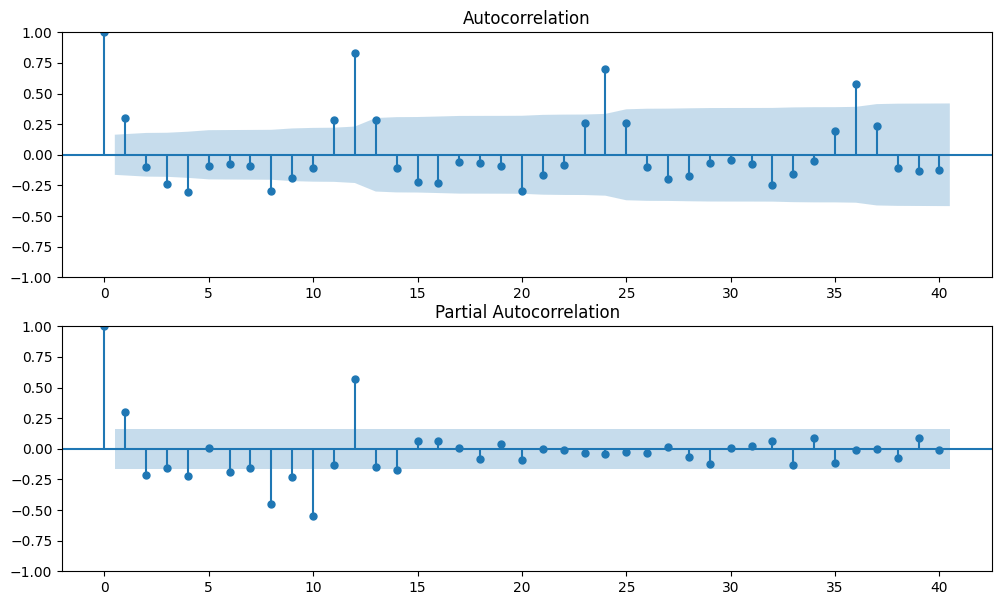

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().dropna(), lags=40, ax=ax[1])
plt.show()

- p = 2 since 2 points are outside C.I in pacf
- d = 1 1st order difference
- q = 1 since 1 value is outside C.I in acf

seasonal order so consider datapoint at seasonal periods only i.e 12,24,36 etc
- P=1 since 1 outlier at 12 in pcf
- D=0
- Q=3 since 3 outliers at 12,24,36  in acf

model training

In [28]:
p=2
d=1
q=1
P=1
D=0
Q=3
# define the arima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['#Passengers'], order=(p, d, q),seasonal_order=(P, D, Q, seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary());

c:\Users\sathv\Desktop\eda\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sathv\Desktop\eda\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\sathv\Desktop\eda\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\sathv\Desktop\eda\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -563.224
Date:                                    Wed, 07 Aug 2024   AIC                           1142.448
Time:                                            22:01:29   BIC                           1166.151
Sample:                                        01-01-1949   HQIC                          1152.080
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6249      0.101      6.167      0

c:\Users\sathv\Desktop\eda\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


forecasting for next 24 months

In [29]:
# forecast for next 2 years
forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], 
                               periods=forecast_steps+1, 
                               freq='M'
                                )[1:].strftime('%Y-%m') # remove start date

C:\Users\sathv\AppData\Local\Temp\ipykernel_3656\2795503596.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1],


In [30]:
# create a forecast dataframe
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:, 0]),
    "Upper CI": list(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

forecast_df.head()

,Forecast,Lower CI,Upper CI
1961-01,446.729615,424.884139,468.575091
1961-02,423.356189,397.213617,449.498762
1961-03,456.483604,426.859934,486.107274
1961-04,491.601475,459.560293,523.642657
1961-05,505.179491,471.286531,539.072451


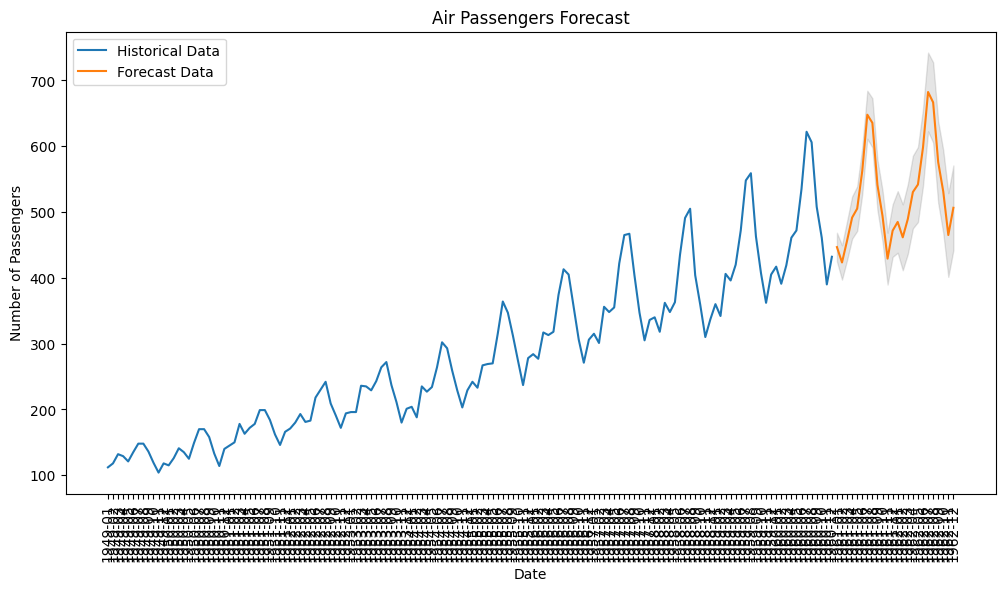

In [31]:
# plot the forecast values

plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()